In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 🟩 1. Cargar el archivo Excel
df = pd.read_excel("Desercion.xlsx", sheet_name="Presencial")

# 🟩 2. Variables seleccionadas
features = [
    'SEXO', 'estu_edad Pruebas de estado', 'estu_area_residePruebas de estado',
    'Lenguaje', 'Matematicas', 'Sociales_y_ciudadanas', 'C_Naturales', 'Ingles',
    'fami_educa_padre', 'fami_educa_madre', 'fami_nivel_sisben', 'fami_ing_fmiliar_mensual',
    'cole_valor_pensionPruebas de estado', 'TIPO_ACEPTACION', 'NIVEL_PREGRADO',
    'SEMESTRE_INICIA_PROGRAMA', 'NUMSEMESTRES', 'CRED_APROB_PROG'
]
target = 'RANGO'


In [25]:
# 🟩 3. Filtrar columnas
df_modelo = df[features + [target]].copy()

# (Opcional) Reemplazar etiquetas si alguna es redundante
# df_modelo[target] = df_modelo[target].replace({
#     'PER-PRUEBA': 'NORMAL',
#     'SOBRESALIE': 'NORMAL'
# })

print("✅ Clases reales antes de codificar:")
print(df_modelo[target].value_counts())

# 🟩 4. Llenar nulos
for col in df_modelo.columns:
    if df_modelo[col].dtype == 'object':
        df_modelo[col] = df_modelo[col].fillna("Desconocido")
    else:
        df_modelo[col] = df_modelo[col].fillna(0)

# 🟩 5. Codificar variables categóricas
label_encoders = {}
for col in df_modelo.select_dtypes(include='object').columns:
    if col != target:  # NO codificamos target aquí
        le = LabelEncoder()
        df_modelo[col] = le.fit_transform(df_modelo[col])
        label_encoders[col] = le

# 🟩 6. Codificar columna objetivo por separado
le_target = LabelEncoder()
df_modelo[target] = le_target.fit_transform(df_modelo[target])
clases = le_target.classes_  # Para visualización posterior

# 🟩 7. Separar y escalar
X = df_modelo[features]
y = df_modelo[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🟩 8. Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


✅ Clases reales antes de codificar:
RANGO
INSUFICIEN    1870
NORMAL         657
PER-PRUEBA     226
SOBRESALIE       7
Name: count, dtype: int64


Fitting 5 folds for each of 48 candidates, totalling 240 fits
🔧 Mejores parámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.005}
✅ Accuracy: 0.73

📋 Classification Report:
              precision    recall  f1-score   support

  INSUFICIEN       0.76      0.92      0.83       374
      NORMAL       0.61      0.46      0.52       131
  PER-PRUEBA       0.00      0.00      0.00        45
  SOBRESALIE       0.00      0.00      0.00         2

    accuracy                           0.73       552
   macro avg       0.34      0.34      0.34       552
weighted avg       0.66      0.73      0.69       552



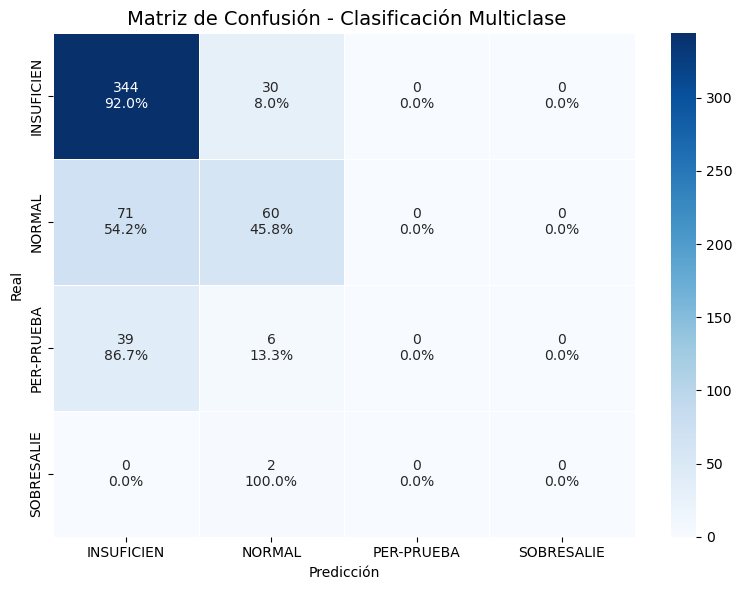

In [27]:
# 🟩 9. GridSearch para MLP
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (40, 60, 40)],
    'activation': ['relu'],  # relu suele ser mejor que tanh
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.005]
}


mlp = MLPClassifier(max_iter=2000, early_stopping=True, random_state=42)
grid = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

# 🟩 10. Evaluación del mejor modelo
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("🔧 Mejores parámetros:", grid.best_params_)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=clases, zero_division=0))

# 🟩 11. Matriz de Confusión con porcentajes
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100

# Crear etiquetas con porcentaje y cantidad
labels = np.array([
    [f"{val}\n{pct:.1f}%" for val, pct in zip(row_vals, row_pcts)]
    for row_vals, row_pcts in zip(cm, cm_percent)
])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=clases, yticklabels=clases,
            linewidths=0.5, linecolor='white')
plt.title(" Matriz de Confusión - Clasificación Multiclase", fontsize=14)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()



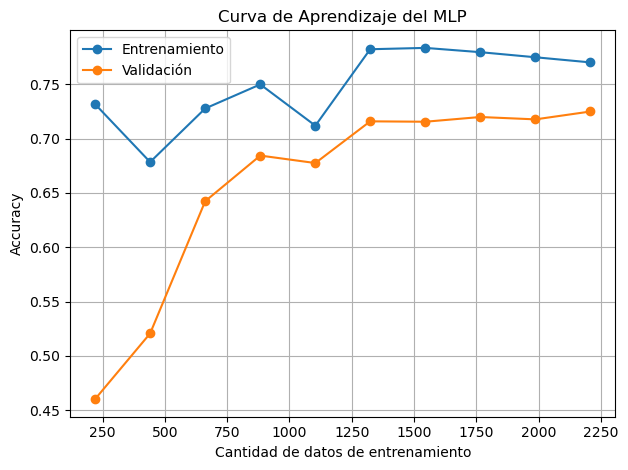

In [29]:
# 🟩 12. Curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_scaled, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Entrenamiento", marker='o')
plt.plot(train_sizes, test_mean, label="Validación", marker='o')
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Curva de Aprendizaje del MLP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [31]:
print(df['RANGO'].value_counts())


RANGO
INSUFICIEN    1870
NORMAL         657
PER-PRUEBA     226
SOBRESALIE       7
Name: count, dtype: int64


In [ ]:
#////////////////////////////////////////////////////////////

Fitting 5 folds for each of 48 candidates, totalling 240 fits
🔧 Mejores parámetros: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (80,), 'learning_rate': 'constant', 'learning_rate_init': 0.005}
✅ Accuracy: 0.71

📋 Classification Report:
              precision    recall  f1-score   support

      ACTIVO       0.54      0.40      0.46       131
    DESERTOR       0.75      0.91      0.82       374
    GRADUADO       0.00      0.00      0.00        47

    accuracy                           0.71       552
   macro avg       0.43      0.44      0.43       552
weighted avg       0.64      0.71      0.67       552



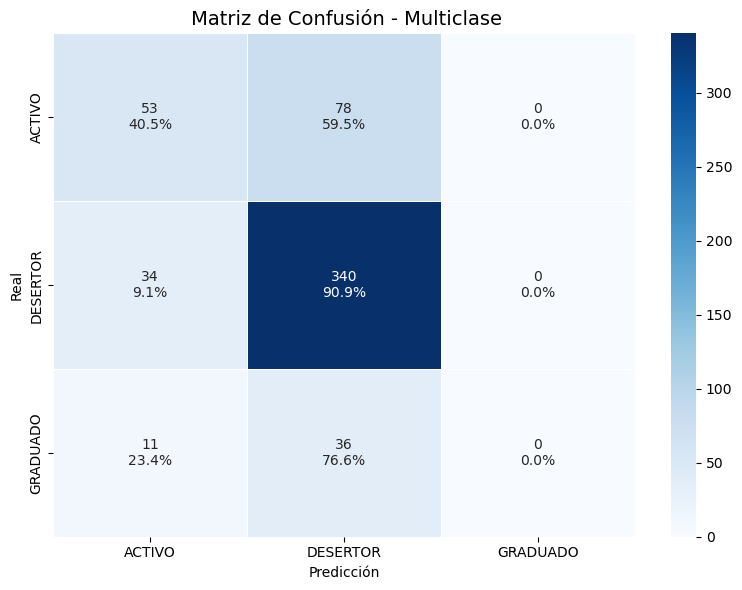

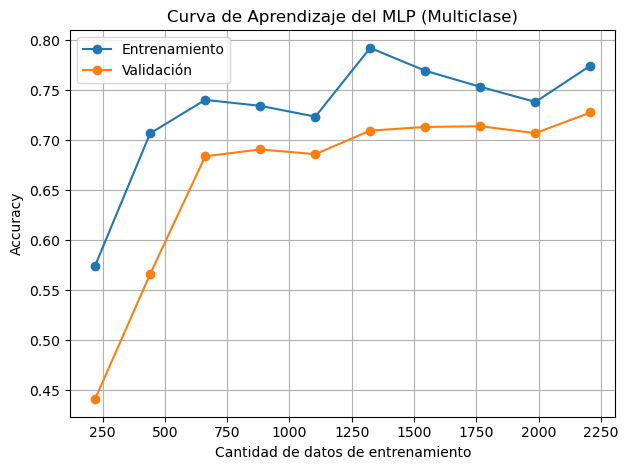

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Cargar datos
df = pd.read_excel("Desercion.xlsx", sheet_name="Presencial")

# 2. Variables seleccionadas
features = [
    'SEXO', 'estu_edad Pruebas de estado', 'estu_area_residePruebas de estado',
    'Lenguaje', 'Matematicas', 'Sociales_y_ciudadanas', 'C_Naturales', 'Ingles',
    'fami_educa_padre', 'fami_educa_madre', 'fami_nivel_sisben', 'fami_ing_fmiliar_mensual',
    'cole_valor_pensionPruebas de estado', 'TIPO_ACEPTACION', 'NIVEL_PREGRADO',
    'SEMESTRE_INICIA_PROGRAMA', 'NUMSEMESTRES', 'CRED_APROB_PROG'
]
target = 'RANGO'

# 3. Reasignar clases
df[target] = df[target].replace({
    'INSUFICIEN': 'DESERTOR',
    'NORMAL': 'ACTIVO',
    'PER-PRUEBA': 'GRADUADO',
    'SOBRESALIE': 'GRADUADO'
})

# 4. Filtrar columnas
df_modelo = df[features + [target]].copy()

# 5. Llenar nulos
for col in df_modelo.columns:
    if df_modelo[col].dtype == 'object':
        df_modelo[col] = df_modelo[col].fillna("Desconocido")
    else:
        df_modelo[col] = df_modelo[col].fillna(0)

# 6. Codificación
label_encoders = {}
for col in df_modelo.select_dtypes(include='object').columns:
    if col != target:
        le = LabelEncoder()
        df_modelo[col] = le.fit_transform(df_modelo[col])
        label_encoders[col] = le

le_target = LabelEncoder()
df_modelo[target] = le_target.fit_transform(df_modelo[target])
clases = le_target.classes_  # ['ACTIVO', 'DESERTOR', 'GRADUADO']

# 7. Separar y escalar
X = df_modelo[features]
y = df_modelo[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 8. División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# 9. GridSearchCV para optimización
param_grid = {
    'hidden_layer_sizes': [(40,), (80,), (50, 50), (40, 60, 40)],
    'activation': ['relu'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.005]
}

mlp = MLPClassifier(max_iter=2000, early_stopping=True, random_state=42)
grid = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

# 10. Evaluación
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("🔧 Mejores parámetros:", grid.best_params_)
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=clases, zero_division=0))

# 11. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum(axis=1, keepdims=True) * 100
labels = np.array([
    [f"{val}\n{pct:.1f}%" for val, pct in zip(row_vals, row_pcts)]
    for row_vals, row_pcts in zip(cm, cm_percent)
])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues',
            xticklabels=clases, yticklabels=clases,
            linewidths=0.5, linecolor='white')
plt.title(" Matriz de Confusión - Multiclase", fontsize=14)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 12. Curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_scaled, y, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label="Entrenamiento", marker='o')
plt.plot(train_sizes, test_mean, label="Validación", marker='o')
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Accuracy")
plt.title("Curva de Aprendizaje del MLP (Multiclase)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#/////////////////////////////////